<a href="https://colab.research.google.com/github/AnIsAsPe/LogisticRegression_SpamOpinion/blob/master/Notebooks/Clasificador_rese%C3%B1as_Regresi%C3%B3n_log%C3%ADstica_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cargar Bibliotecas

In [1]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Funciones

In [2]:
def elimina_stopwords(texto):
  '''La función usa expresiones regulares (re) para quitar todas las palabras 
  que sean una palabra vacia:'''
  stop = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
  nuevo_texto = stop.sub('', texto)
  return nuevo_texto

# https://www.regular-expressions.info/index.html
# https://www.tutorialspoint.com/Why-do-we-use-re-compile-method-in-Python-regular-expression

In [3]:
elimina_stopwords("I love how you cook".lower())

'love cook'

In [4]:
def elimina_puntuacion_y_numeros(texto):
  nuevo_texto = re.sub('[^a-z]+', ' ', texto)
  return nuevo_texto


In [5]:
elimina_puntuacion_y_numeros("Is he 8 years old?".lower())

'is he years old '

In [6]:
"Is he 8 years old?".split()

['Is', 'he', '8', 'years', 'old?']

In [7]:
def lematizar(texto):
  lemma = WordNetLemmatizer()
  texto = texto.split()
  texto2 = " ".join([lemma.lemmatize(i, 'v') for i in texto])
  nuevo_texto = " ".join([lemma.lemmatize(i, 'v') for i in texto])
  return nuevo_texto

In [8]:
lematizar("ran run running")

'run run run'

In [9]:
def stemmer(texto):
  st = PorterStemmer()
  texto = texto.split()
  nuevo_texto = ' '.join([st.stem(i) for i in texto])
  return nuevo_texto

In [10]:
stemmer("ran run running")

'ran run run'

In [11]:
def preprocesar(texto):
  texto = texto.lower()
  texto = elimina_stopwords(texto)
  texto = elimina_puntuacion_y_numeros(texto)
  texto = stemmer(texto)
  return(texto)


# Lectura de datos y breve exploración

In [12]:
datos = pd.read_csv('https://raw.githubusercontent.com/AnIsAsPe/LogisticRegression_SpamOpinion/master/Datos/deceptive-opinion.csv',
                     usecols=['deceptive','text']
                    )
print(datos.shape)
datos.head()

(1600, 2)


,deceptive,text
0,truthful,We stayed for a one night getaway with family ...
1,truthful,Triple A rate with upgrade to view room was le...
2,truthful,This comes a little late as I'm finally catchi...
3,truthful,The Omni Chicago really delivers on all fronts...
4,truthful,I asked for a high floor away from the elevato...


In [13]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   deceptive  1600 non-null   object
 1   text       1600 non-null   object
dtypes: object(2)
memory usage: 25.1+ KB


In [14]:
datos.deceptive.value_counts()

truthful     800
deceptive    800
Name: deceptive, dtype: int64

In [15]:
# datos['deceptive'] = np.where(datos['deceptive']=='deceptive', 1, 0)
# datos['deceptive'].value_counts()

In [16]:
y = datos['deceptive']

# Preprocesamiento de texto

In [17]:
datos['text']

0       We stayed for a one night getaway with family ...
1       Triple A rate with upgrade to view room was le...
2       This comes a little late as I'm finally catchi...
3       The Omni Chicago really delivers on all fronts...
4       I asked for a high floor away from the elevato...
                              ...                        
1595    Problems started when I booked the InterContin...
1596    The Amalfi Hotel has a beautiful website and i...
1597    The Intercontinental Chicago Magnificent Mile ...
1598    The Palmer House Hilton, while it looks good i...
1599    As a former Chicagoan, I'm appalled at the Ama...
Name: text, Length: 1600, dtype: object

In [18]:
datos['long_text'] = datos['text'].str.len()

In [19]:
datos 

,deceptive,text,long_text
0,truthful,We stayed for a one night getaway with family ...,572
1,truthful,Triple A rate with upgrade to view room was le...,286
2,truthful,This comes a little late as I'm finally catchi...,1104
3,truthful,The Omni Chicago really delivers on all fronts...,707
4,truthful,I asked for a high floor away from the elevato...,384
...,...,...,...
1595,deceptive,Problems started when I booked the InterContin...,746
1596,deceptive,The Amalfi Hotel has a beautiful website and i...,671
1597,deceptive,The Intercontinental Chicago Magnificent Mile ...,771
1598,deceptive,"The Palmer House Hilton, while it looks good i...",449


In [20]:
datos[datos['long_text']==datos['long_text'].max()]

,deceptive,text,long_text
998,truthful,I was very much looking forward to our stay at...,4159


In [21]:
indice = 998
ejemplo = datos.loc[indice, 'text']
print(len(ejemplo))
ejemplo

4159


"I was very much looking forward to our stay at this hotel, after hearing all the good things about it. Unfortunately, it was a very underwhelming experience, to say the least. But let me begin with the things that I do like about the hotel. First off, it is located my favorite part of Chicago - the leafy, affluent part of town that is Chicago's equivalent of Manhattan's Upper East Side, complete with sidewalks, quiet tree-lined streets, real old-school townhouses (instead of ugly towering monstrosities that are 21st century condominiums), cute boutiques (instead of Gap, Banana Republic and other mainstream mass-produced brands) and, of course, Hermes of Paris (which warrants a separate mention). I also like the small intimate lobby area with old leather couches, cherry colored wooden furnitures, area rugs and distinct artwork. The very reason why I always tend to gravitate toward smaller boutique hotels instead of impersonal chains. I definitely love the room. While the space issue is

#### Transformar texto a minúsculas

In [22]:
ejemplo = ejemplo.lower()
print(len(ejemplo))
ejemplo

4159


"i was very much looking forward to our stay at this hotel, after hearing all the good things about it. unfortunately, it was a very underwhelming experience, to say the least. but let me begin with the things that i do like about the hotel. first off, it is located my favorite part of chicago - the leafy, affluent part of town that is chicago's equivalent of manhattan's upper east side, complete with sidewalks, quiet tree-lined streets, real old-school townhouses (instead of ugly towering monstrosities that are 21st century condominiums), cute boutiques (instead of gap, banana republic and other mainstream mass-produced brands) and, of course, hermes of paris (which warrants a separate mention). i also like the small intimate lobby area with old leather couches, cherry colored wooden furnitures, area rugs and distinct artwork. the very reason why i always tend to gravitate toward smaller boutique hotels instead of impersonal chains. i definitely love the room. while the space issue is

#### Quitar puntuación

In [23]:
ejemplo = elimina_puntuacion_y_numeros(ejemplo)
print(len(ejemplo))
ejemplo

4013


'i was very much looking forward to our stay at this hotel after hearing all the good things about it unfortunately it was a very underwhelming experience to say the least but let me begin with the things that i do like about the hotel first off it is located my favorite part of chicago the leafy affluent part of town that is chicago s equivalent of manhattan s upper east side complete with sidewalks quiet tree lined streets real old school townhouses instead of ugly towering monstrosities that are st century condominiums cute boutiques instead of gap banana republic and other mainstream mass produced brands and of course hermes of paris which warrants a separate mention i also like the small intimate lobby area with old leather couches cherry colored wooden furnitures area rugs and distinct artwork the very reason why i always tend to gravitate toward smaller boutique hotels instead of impersonal chains i definitely love the room while the space issue is not as bad in chicago as it is

#### Quitar Palabras Irrelevantes ("Stopwords")

In [24]:
ejemplo = elimina_stopwords(ejemplo)
print(len(ejemplo))
ejemplo

2624


'much looking forward stay hotel hearing good things unfortunately underwhelming experience say least let begin things like hotel first located favorite part chicago leafy affluent part town chicago equivalent manhattan upper east side complete sidewalks quiet tree lined streets real old school townhouses instead ugly towering monstrosities st century condominiums cute boutiques instead gap banana republic mainstream mass produced brands course hermes paris warrants separate mention also like small intimate lobby area old leather couches cherry colored wooden furnitures area rugs distinct artwork reason always tend gravitate toward smaller boutique hotels instead impersonal chains definitely love room space issue bad chicago manhattan getting sqft guestroom weekend getaway easy task delighted see room comes generous ample bathroom double sink massive king bed still enough space walk around chicken dance strut herve louboutins reservation lack natural light windows definitely inadequate

## Normalización
Existen dos principales técnicas para normalizar el texto, la lematización y "radicalización" o stemming, que consiste en la  conversión de palabras en las raices

Referencia: 

https://towardsdatascience.com/introduction-to-nlp-part-2-difference-between-lemmatisation-and-stemming-3789be1c55bc

In [25]:
ejemplo_lema = lematizar(ejemplo)
print(len(ejemplo_lema))
ejemplo_lema

2530


'much look forward stay hotel hear good things unfortunately underwhelming experience say least let begin things like hotel first locate favorite part chicago leafy affluent part town chicago equivalent manhattan upper east side complete sidewalks quiet tree line streets real old school townhouses instead ugly tower monstrosities st century condominiums cute boutiques instead gap banana republic mainstream mass produce brand course hermes paris warrant separate mention also like small intimate lobby area old leather couch cherry color wooden furnitures area rugs distinct artwork reason always tend gravitate toward smaller boutique hotels instead impersonal chain definitely love room space issue bad chicago manhattan get sqft guestroom weekend getaway easy task delight see room come generous ample bathroom double sink massive king bed still enough space walk around chicken dance strut herve louboutins reservation lack natural light windows definitely inadequate allow sunlight find way t

In [26]:
ejemplo_stem = stemmer(ejemplo)
print(len(ejemplo))
ejemplo_stem

2624


'much look forward stay hotel hear good thing unfortun underwhelm experi say least let begin thing like hotel first locat favorit part chicago leafi affluent part town chicago equival manhattan upper east side complet sidewalk quiet tree line street real old school townhous instead ugli tower monstros st centuri condominium cute boutiqu instead gap banana republ mainstream mass produc brand cours herm pari warrant separ mention also like small intim lobbi area old leather couch cherri color wooden furnitur area rug distinct artwork reason alway tend gravit toward smaller boutiqu hotel instead imperson chain definit love room space issu bad chicago manhattan get sqft guestroom weekend getaway easi task delight see room come gener ampl bathroom doubl sink massiv king bed still enough space walk around chicken danc strut herv louboutin reserv lack natur light window definit inadequ allow sunlight find way th floor room delawar st exactli widest street town build front us yet one thing rea

## Todo junto

In [27]:
datos['text_pp'] = datos['text'].apply(preprocesar)
datos['long_text_pp'] = datos['text_pp'].str.len()
datos.head()

,deceptive,text,long_text,text_pp,long_text_pp
0,truthful,We stayed for a one night getaway with family ...,572,stay one night getaway famili thursday tripl a...,340
1,truthful,Triple A rate with upgrade to view room was le...,286,tripl rate upgrad view room less also includ b...,186
2,truthful,This comes a little late as I'm finally catchi...,1104,come littl late final catch review past sever ...,624
3,truthful,The Omni Chicago really delivers on all fronts...,707,omni chicago realli deliv front spacious room ...,387
4,truthful,I asked for a high floor away from the elevato...,384,ask high floor away elev got room pleasantli d...,197


# Visualización de nubes de palabras

In [41]:
def nube_palabras(sec_textos):
    # Crear la cadena con la que haremos la nube de palabras
    text= " ".join(review for review in sec_textos)
    
    # Crear la nube de palabras
    wordcloud = WordCloud(max_font_size=50, 
                          max_words=100, 
                          background_color="white").generate(text)

    # Desplegar la imagen generada
    plt.figure(figsize=[10,12])
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

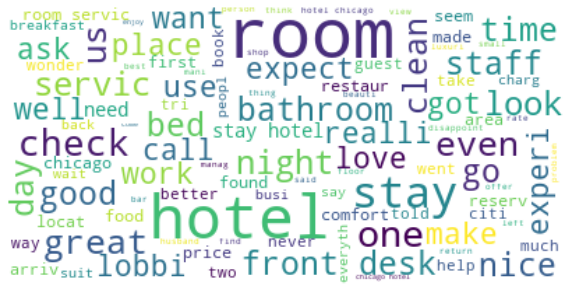

In [42]:
nube_palabras(datos['text_pp'])

In [43]:
porClase = datos.groupby('deceptive')
verdaderas = porClase.get_group('truthful').text_pp
falsas = porClase.get_group('deceptive').text_pp

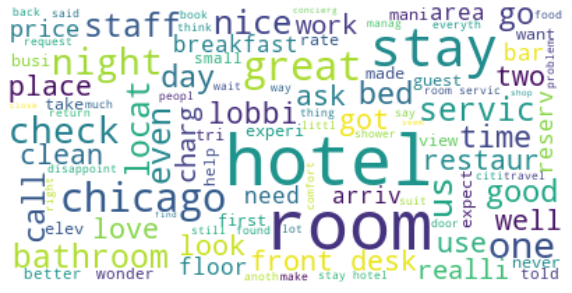

In [44]:
nube_palabras(verdaderas)

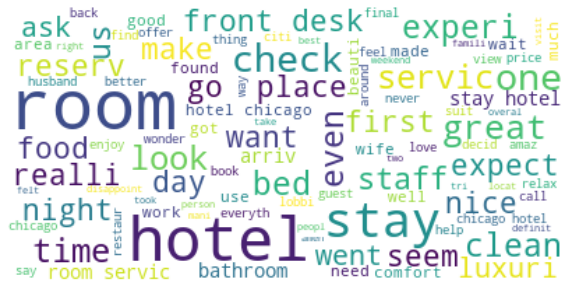

In [45]:
nube_palabras(falsas)

# Vectorización de Texto mediante BOW

In [46]:
vectorizer = TfidfVectorizer(min_df=2)
BOW = vectorizer.fit_transform(datos['text_pp'])
BOW.shape

(1600, 3616)

In [47]:
palabras = vectorizer.get_feature_names_out()
X = pd.DataFrame(BOW.todense(), index=datos.index, columns=palabras)
X

,aaa,abil,abl,abrupt,absenc,absent,absolut,absurd,abund,abysm,...,york,young,younger,yr,yuck,yummi,yup,zest,zone,zoo
0,0.1882,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0000,0.0,0.084973,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,0.0000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1596,0.0000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1597,0.0000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1598,0.0000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Regresión Logística sin penalización

In [48]:
# Dividir datos en entrenamiento y prueba
X_train, X_test , y_train, y_test = train_test_split(X, y, 
                                                     test_size=0.2, 
                                                     shuffle=True,   
                                                     random_state=9
                                                     )

clasificador_rl = LogisticRegression(penalty= 'none',
                                     random_state=4, 
                                     solver="newton-cg").fit(X_train, y_train)
clasificador_rl.score(X_test, y_test)

0.85625

In [49]:
def evaluación(modelo, conjunto):
    mensaje_error = 'conjunto solo puede ser "entrenamieonto" o "prueba"'
    assert conjunto in ['entrenamiento', 'prueba'], mensaje_error


    if conjunto == 'entrenamiento':
      X = X_train
      y = y_train
    else:
      X = X_test
      y = y_test    
   

    y_pred = modelo.predict(X)
    precision = accuracy_score(y, y_pred)*100

    # creamos un diccionario con las etiquetas
    data = {'y_Real':  y,
            'y_Prediccion': y_pred
            }
    # lo convertimos en un DataFrame de pandas
    df = pd.DataFrame(data, columns=['y_Real','y_Prediccion'])

    # hacemos una tabla crusada para obtener la matriz de confusión
    confusion_matrix = pd.crosstab(df['y_Real'], df['y_Prediccion'], 
                                   rownames=['Real'], colnames=['Predicción'])

    # realizamos un mapa de calor
    titulo = 'Datos:{}, precisión = {:4.2f}'.format(conjunto, precision)
    sns.heatmap(confusion_matrix, annot=True, fmt='g').set(title = titulo)
    plt.show()


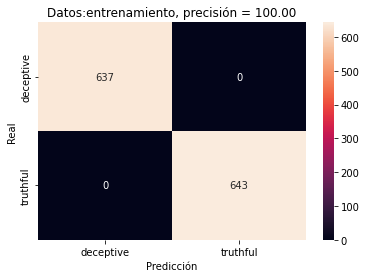

In [50]:
evaluación(clasificador_rl, 'entrenamiento')

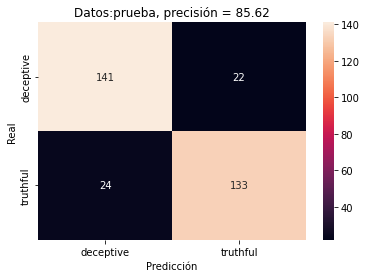

In [51]:
evaluación(clasificador_rl, 'prueba')

# Regresión Logística con penalización Ridge

## ¿De qué magnitud debe ser la fueza de la regularización (parámetro  λ)?

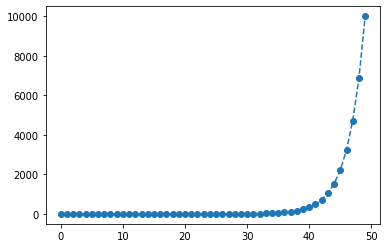

In [52]:
lambdas = np.logspace(-4, 4, 50)
plt.plot(lambdas, linestyle='--', marker='o')
plt.show()

In [53]:
lambdas

array([1.00000000e-04, 1.45634848e-04, 2.12095089e-04, 3.08884360e-04,
       4.49843267e-04, 6.55128557e-04, 9.54095476e-04, 1.38949549e-03,
       2.02358965e-03, 2.94705170e-03, 4.29193426e-03, 6.25055193e-03,
       9.10298178e-03, 1.32571137e-02, 1.93069773e-02, 2.81176870e-02,
       4.09491506e-02, 5.96362332e-02, 8.68511374e-02, 1.26485522e-01,
       1.84206997e-01, 2.68269580e-01, 3.90693994e-01, 5.68986603e-01,
       8.28642773e-01, 1.20679264e+00, 1.75751062e+00, 2.55954792e+00,
       3.72759372e+00, 5.42867544e+00, 7.90604321e+00, 1.15139540e+01,
       1.67683294e+01, 2.44205309e+01, 3.55648031e+01, 5.17947468e+01,
       7.54312006e+01, 1.09854114e+02, 1.59985872e+02, 2.32995181e+02,
       3.39322177e+02, 4.94171336e+02, 7.19685673e+02, 1.04811313e+03,
       1.52641797e+03, 2.22299648e+03, 3.23745754e+03, 4.71486636e+03,
       6.86648845e+03, 1.00000000e+04])

In [54]:
%%time
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(LogisticRegression(penalty='l2',max_iter=500), 
                           { 'C': 1/lambdas}, cv=5, return_train_score=False)
grid_search.fit(X, y)

CPU times: user 2min 43s, sys: 43.7 s, total: 3min 27s
Wall time: 1min 46s


In [ ]:
grid_search.best_params_

{'C': 3.7275937203149416}

In [ ]:
C = grid_search.best_params_['C']

# valor de lambda
1 / grid_search.best_params_['C']

0.2682695795279725

In [ ]:
clasificador_ridge = LogisticRegression(penalty= 'l2',  
                                        C = C, 
                                        random_state=4, 
                                        solver="newton-cg").fit(X_train, y_train)

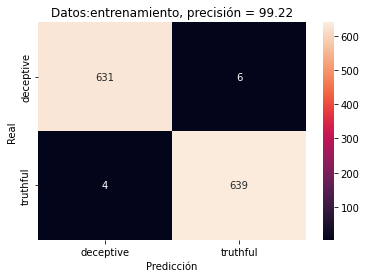

In [ ]:
evaluación(clasificador_ridge, 'entrenamiento')

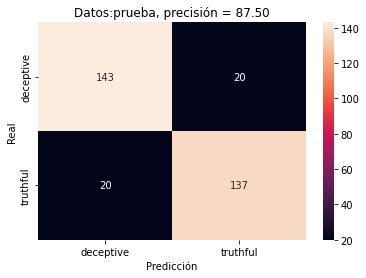

In [ ]:
evaluación(clasificador_ridge, 'prueba')

# Predicciones y certeza de la predicción

In [ ]:
resultados = {'P(deceptive)' : clasificador_rl.predict_proba(X_test)[:,0],
              'P(truthful)' : clasificador_rl.predict_proba(X_test)[:,1], 
              'y_pred_50' : clasificador_rl.predict(X_test),          
              }

predicciones = pd.DataFrame(resultados)
predicciones.sort_values('P(deceptive)',
                         ascending=False).iloc[155:165]

,P(deceptive),P(truthful),y_pred_50
132,0.736305,0.263695,deceptive
153,0.728104,0.271896,deceptive
149,0.682137,0.317863,deceptive
313,0.645260,0.354740,deceptive
205,0.640744,0.359256,deceptive
191,0.614963,0.385037,deceptive
286,0.582905,0.417095,deceptive
102,0.558283,0.441717,deceptive
22,0.543162,0.456838,deceptive
224,0.522063,0.477937,deceptive


In [ ]:
predicciones['y_pred_60'] = np.where( predicciones['P(deceptive)'] > .6, 'deceptive', 'truthful')
predicciones.sort_values('P(deceptive)',
                         ascending=False).iloc[155:165]

,P(deceptive),P(truthful),y_pred_50,y_pred_60
132,0.736305,0.263695,deceptive,deceptive
153,0.728104,0.271896,deceptive,deceptive
149,0.682137,0.317863,deceptive,deceptive
313,0.645260,0.354740,deceptive,deceptive
205,0.640744,0.359256,deceptive,deceptive
191,0.614963,0.385037,deceptive,deceptive
286,0.582905,0.417095,deceptive,truthful
102,0.558283,0.441717,deceptive,truthful
22,0.543162,0.456838,deceptive,truthful
224,0.522063,0.477937,deceptive,truthful


# Magnitud de los coeficientes para ambos modelos

In [ ]:
coeficientes_rl = pd.Series(clasificador_rl.coef_[0], 
                            index=palabras,
                            name='Sin regularización').sort_values(ascending=False)
coeficientes_rl

floor         37.788578
street        36.411060
locat         34.536465
small         31.756317
elev          31.142357
                ...    
definit      -27.971250
relax        -28.005217
millennium   -30.007903
luxuri       -40.155852
chicago      -60.849421
Name: Sin regularización, Length: 3616, dtype: float64

In [ ]:
coeficientes_ridge = pd.Series(clasificador_ridge.coef_[0],
                               index=palabras,
                               name='Ridge').sort_values(ascending=False)
coeficientes_ridge

locat      3.669680
floor      3.626754
elev       3.157466
small      3.080319
street     2.926056
             ...   
seem      -2.784388
relax     -2.809551
experi    -3.038623
luxuri    -4.518904
chicago   -6.871216
Name: Ridge, Length: 3616, dtype: float64

In [ ]:
# Observa las magnitudes de los coeficientes del modelo
#  sin y con regularización Ridge
pd.concat([coeficientes_rl,coeficientes_ridge], axis=1)

,Sin regularización,Ridge
floor,37.788578,3.626754
street,36.411060,2.926056
locat,34.536465,3.669680
small,31.756317,3.080319
elev,31.142357,3.157466
...,...,...
definit,-27.971250,-2.642085
relax,-28.005217,-2.809551
millennium,-30.007903,-2.757804
luxuri,-40.155852,-4.518904


In [ ]:
# importancia de las palabras para predecir que es falsa la reseña
np.exp(coeficientes_ridge)

locat      39.239362
floor      37.590582
elev       23.510940
small      21.765346
street     18.653922
             ...    
seem        0.061767
relax       0.060232
experi      0.047901
luxuri      0.010901
chicago     0.001037
Name: Ridge, Length: 3616, dtype: float64

# Recursos

Para profundizar en grid_search_cv

https://github.com/codebasics/py/blob/master/ML/15_gridsearch/15_grid_search.ipynb